Plant Disease Classification Project: 
first we are importing all the necessary libraies and loading the dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


Loading the DataSet

In [2]:
image_size = 256
batch_size = 32
channels = 3 
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True,
)

class_names = data_set.class_names
print(class_names)
num_of_classes = len(class_names)
print(type(num_of_classes))

Found 2152 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
<class 'int'>


12


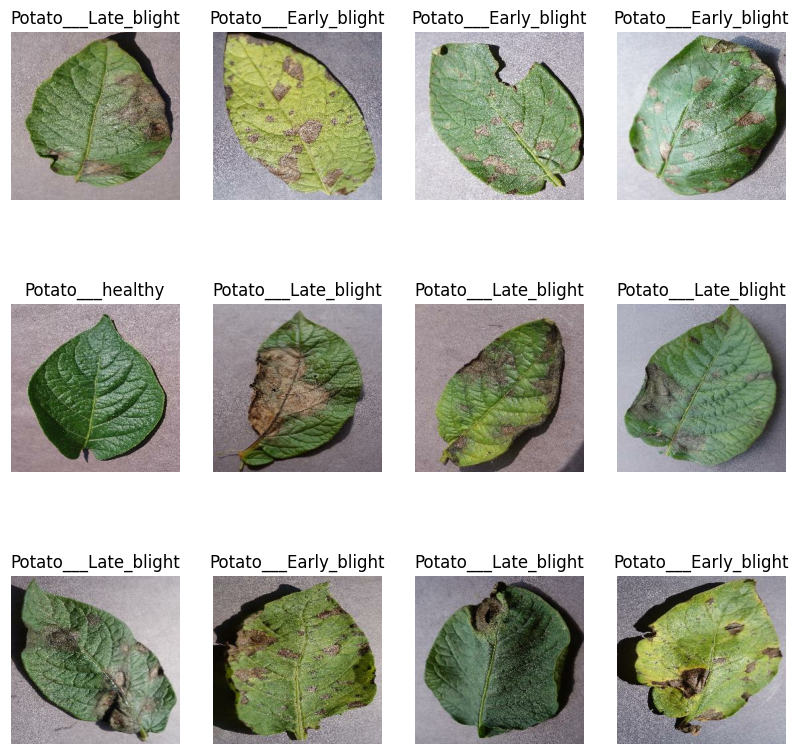

In [3]:
count = 0
plt.figure(figsize=(10,10))

for i in range(12):
    for img ,leb in data_set.take(1):
        plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(label= class_names[leb[i].numpy()])
        plt.axis("off")
        #print(img[0].numpy())
        count+=1
print(count)


In [4]:
for img,leb in data_set.take(1):
    print(class_names[leb[0].numpy()])

Potato___Early_blight


Now we are splitting the dataset in 3 parts train, validation, test dataset in a percentage of 80,10,10

In [5]:
def get_dataset_split(ds=data_set,training_fraction = 0.8 ,validation_fraction = 0.1,test_fraction=0.1,shuffle=True,shuffle_size=1000):
    print("getting started")
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    traing_dataset = ds.take(int(training_fraction*len(ds)))
    validation_dataset = ds.skip(int(training_fraction*len(ds))).take(int(validation_fraction*len(ds)))
    test_dataset = ds.skip(int(training_fraction*len(ds))).skip(int(validation_fraction*len(ds)))

    return traing_dataset,validation_dataset,test_dataset

In [6]:
int(len(data_set)*0.8)

54

In [7]:
train_dataset,val_dataset,test_dataset = get_dataset_split(data_set)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

getting started
54
6
8


Now we will be doing cacheing and prefetching for better performence

In [8]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

Resize and Rescaling

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1.0/255),
    layers.Resizing(image_size,image_size)
])

Adding Random Flip and Random Rotation (Data Augumentation)

In [10]:
random_flip_and_rotate = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

Making our own Custom Model

In [11]:
input_shape = (batch_size,image_size,image_size,channels)
model = tf.keras.Sequential([
    resize_and_rescale,
    random_flip_and_rotate,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),#64 is number of nurons in the first layer
    layers.Dense(num_of_classes,activation="softmax")#output layer with 3 nurons

])

model.build(input_shape)


c:\Users\digan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits =False),
    metrics=['accuracy']
)

Now Let's train the model

In [16]:
history = model.fit(
    train_dataset,
    validation_data =val_dataset,
    epochs = 10,
    verbose = 1,
    batch_size = batch_size
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 606ms/step - accuracy: 0.8547 - loss: 0.4157 - val_accuracy: 0.7396 - val_loss: 0.7109
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 587ms/step - accuracy: 0.8721 - loss: 0.3266 - val_accuracy: 0.9219 - val_loss: 0.2660
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 547ms/step - accuracy: 0.9207 - loss: 0.2160 - val_accuracy: 0.9167 - val_loss: 0.2204
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 550ms/step - accuracy: 0.9225 - loss: 0.2004 - val_accuracy: 0.9427 - val_loss: 0.2196
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 571ms/step - accuracy: 0.9421 - loss: 0.1625 - val_accuracy: 0.9271 - val_loss: 0.1932
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 757ms/step - accuracy: 0.9439 - loss: 0.1442 - val_accuracy: 0.9583 - val_loss: 0.1200
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 624ms/step - accuracy: 0.9282 - loss: 0.1937 - val_accuracy: 0.9375 - val_loss: 0.2061
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 610ms/step - accuracy: 0.9265 - loss: 0.2023 - val_accu

In [19]:
model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.9531 - loss: 0.1163


[0.11631283909082413, 0.953125]

In [35]:
import numpy as np

first image 
actual class  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
predicted class  Potato___Early_blight
first image 
actual class  Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
predicted class  Potato___healthy


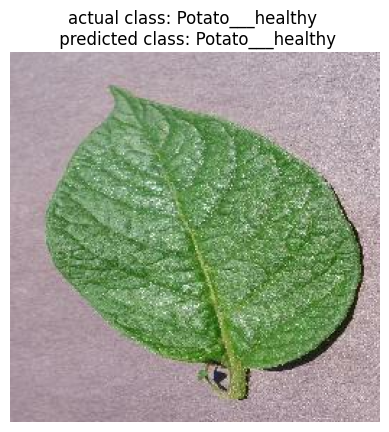

In [ ]:
for img_batch , leb_batch in test_dataset.take(1):
    print("first image ")
    plt.axis("off")
    print("actual class ",class_names[leb_batch[0].numpy()])
    # print(model.predict(img_batch))
    predictions = model.predict(img_batch)
    actual_class = class_names[leb_batch[0].numpy()]
    predicted_class = class_names[np.argmax(predictions[0])]
    print("predicted class ", class_names[np.argmax(predictions[0])])
    plt.imshow(img_batch[0].numpy().astype('uint8'))
    plt.title(f'actual class: {actual_class} \n predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


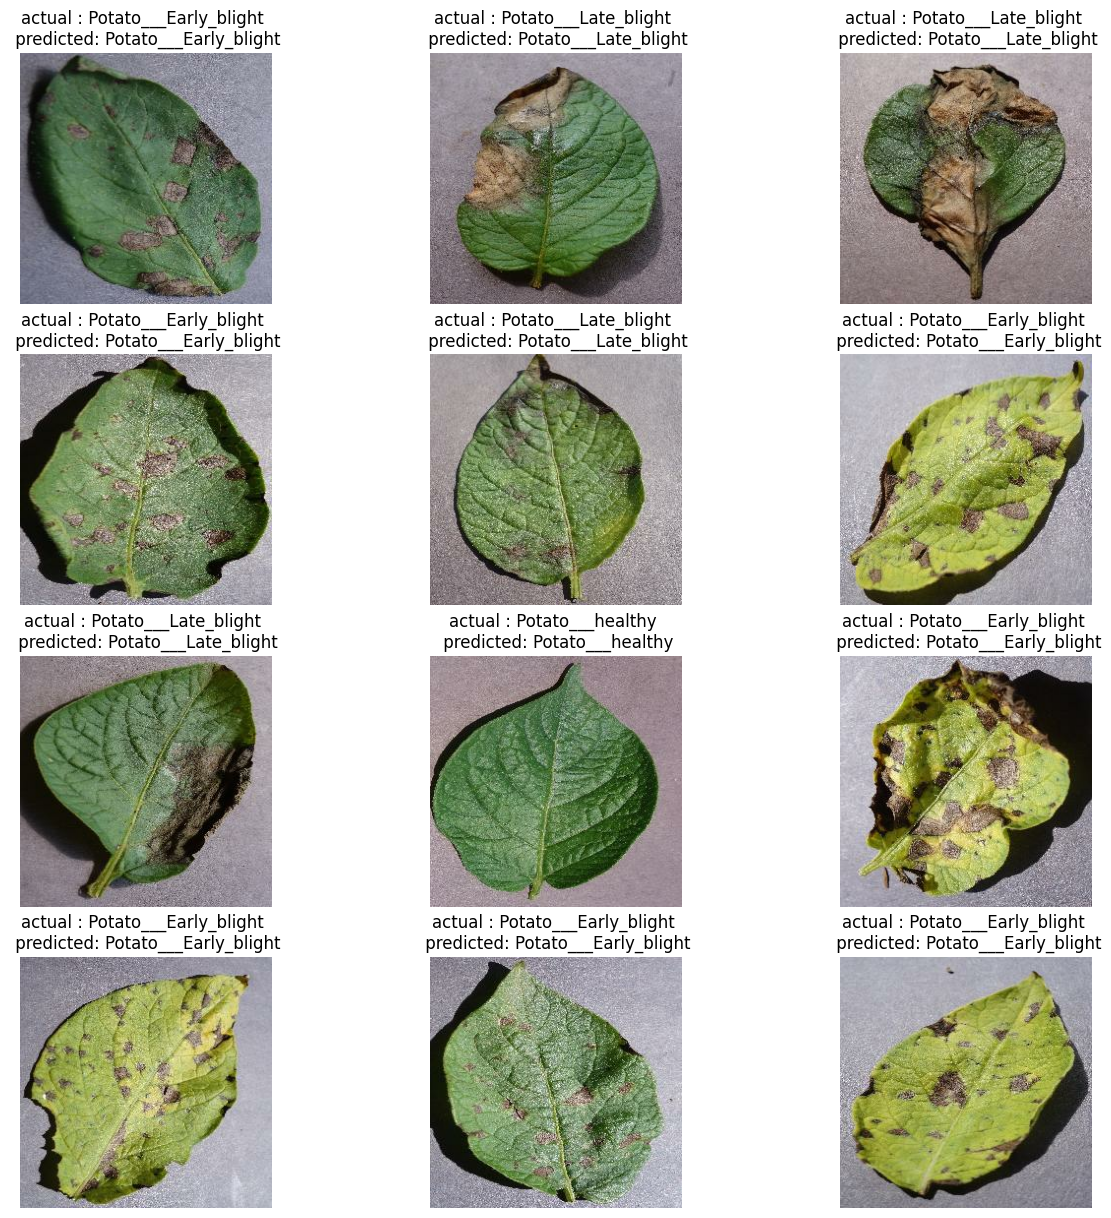

In [152]:
plt.figure(figsize=(15,15))
for i in range(12):
    for img_batch,leb_batch in test_dataset.take(1):
        actual_class = class_names[leb_batch[i].numpy()]
        predicted_class = class_names[np.argmax(model.predict(img_batch)[i])]
        # print("actual class: ",actual_class)
        # print("\n predicted calss: ",predicted_class)
        plt.subplot(4,3,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(f"actual : {actual_class} \n predicted: {predicted_class}")